# Anomaly detection using account and transaction datasets
* No prior label was provided, need to generate our own label for normal--0 and anomaly--1
* Columns:
* For each account the following information is available:
* ACCTTYPE -- account type: Business/Credit

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.rcParams["figure.figsize"] = (20,10)

# 1. import the datasets and join them

In [103]:
account = pd.read_csv('anomaly-detection_anomaly-detection/faccount.txt')
account.set_index('ACCTID',inplace=True)
account.head()

,ACCTTYPE,ACCTNAME,FIRSTNAME,SURNAME,DOB,ACCTCREATED,ACCTRISK,ADDRESS,ADDRESS_LAT,ADDRESS_LON,CATEGORY
ACCTID,,,,,,,,,,,
800039,BUSINESS,Young Supermarket,Kevin,Young,1982-02-23T00:00:00,2018-09-20T00:00:00,MEDIUM,BRISBANE,-27.512179,153.073105,Supermarket
800040,BUSINESS,Williams Grocery,Lindsay,Williams,1959-02-20T00:00:00,2018-02-24T00:00:00,MEDIUM,BRISBANE,-27.504303,153.073470,Grocery
800041,CREDIT,Myers Supermarket,Lisa,Myers,1982-09-04T00:00:00,2018-01-11T00:00:00,HIGH,BRISBANE,-27.484970,153.097588,Supermarket
800042,BUSINESS,Martinez Supermarket,Brittany,Martinez,1976-10-11T00:00:00,2018-12-04T00:00:00,MEDIUM,BRISBANE,-27.402357,153.056983,Supermarket
800043,CREDIT,Taylor Grocery,David,Taylor,1978-01-23T00:00:00,2019-07-15T00:00:00,MEDIUM,BRISBANE,-27.473628,152.955089,Grocery


In [104]:
account_FROMACCT = account.copy()
account_FROMACCT.columns = ['FROMACCT_' + str(col) for col in account_FROMACCT.columns]
account_FROMACCT.head()

,FROMACCT_ACCTTYPE,FROMACCT_ACCTNAME,FROMACCT_FIRSTNAME,FROMACCT_SURNAME,FROMACCT_DOB,FROMACCT_ACCTCREATED,FROMACCT_ACCTRISK,FROMACCT_ADDRESS,FROMACCT_ADDRESS_LAT,FROMACCT_ADDRESS_LON,FROMACCT_CATEGORY
ACCTID,,,,,,,,,,,
800039,BUSINESS,Young Supermarket,Kevin,Young,1982-02-23T00:00:00,2018-09-20T00:00:00,MEDIUM,BRISBANE,-27.512179,153.073105,Supermarket
800040,BUSINESS,Williams Grocery,Lindsay,Williams,1959-02-20T00:00:00,2018-02-24T00:00:00,MEDIUM,BRISBANE,-27.504303,153.073470,Grocery
800041,CREDIT,Myers Supermarket,Lisa,Myers,1982-09-04T00:00:00,2018-01-11T00:00:00,HIGH,BRISBANE,-27.484970,153.097588,Supermarket
800042,BUSINESS,Martinez Supermarket,Brittany,Martinez,1976-10-11T00:00:00,2018-12-04T00:00:00,MEDIUM,BRISBANE,-27.402357,153.056983,Supermarket
800043,CREDIT,Taylor Grocery,David,Taylor,1978-01-23T00:00:00,2019-07-15T00:00:00,MEDIUM,BRISBANE,-27.473628,152.955089,Grocery


In [105]:
account_TOACCT = account.copy()
account_TOACCT.columns = ['TOACCT_' + str(col) for col in account_TOACCT.columns]
account_TOACCT.head()

,TOACCT_ACCTTYPE,TOACCT_ACCTNAME,TOACCT_FIRSTNAME,TOACCT_SURNAME,TOACCT_DOB,TOACCT_ACCTCREATED,TOACCT_ACCTRISK,TOACCT_ADDRESS,TOACCT_ADDRESS_LAT,TOACCT_ADDRESS_LON,TOACCT_CATEGORY
ACCTID,,,,,,,,,,,
800039,BUSINESS,Young Supermarket,Kevin,Young,1982-02-23T00:00:00,2018-09-20T00:00:00,MEDIUM,BRISBANE,-27.512179,153.073105,Supermarket
800040,BUSINESS,Williams Grocery,Lindsay,Williams,1959-02-20T00:00:00,2018-02-24T00:00:00,MEDIUM,BRISBANE,-27.504303,153.073470,Grocery
800041,CREDIT,Myers Supermarket,Lisa,Myers,1982-09-04T00:00:00,2018-01-11T00:00:00,HIGH,BRISBANE,-27.484970,153.097588,Supermarket
800042,BUSINESS,Martinez Supermarket,Brittany,Martinez,1976-10-11T00:00:00,2018-12-04T00:00:00,MEDIUM,BRISBANE,-27.402357,153.056983,Supermarket
800043,CREDIT,Taylor Grocery,David,Taylor,1978-01-23T00:00:00,2019-07-15T00:00:00,MEDIUM,BRISBANE,-27.473628,152.955089,Grocery


In [106]:
transaction = pd.read_csv('anomaly-detection_anomaly-detection/ftxn2.txt')
transaction.set_index('FROMACCTID',inplace=True)
transaction.head()

,TXN_ID,TXTYPE,AMOUNT,TOACCTID,TXDATE,REFERENCE,ISFRAUD,ISFLAGGED
FROMACCTID,,,,,,,,
500607,950060711303,PAYMENT,320,800242,2020-01-22T17:00:00,Dinner with Shane,N,Y
500607,950060711401,PAYMENT,48,800111,2020-01-23T08:00:00,Breakfast with Steven,N,Y
500607,950060711402,TRANSFER,6209,500929,2020-01-23T13:00:00,Holiday Cost,N,Y
500607,950060711403,PAYMENT,66,800252,2020-01-23T17:00:00,Meal with Mary,N,Y
500607,950060711501,PAYMENT,47,800116,2020-01-24T08:00:00,Coffee with Brian,N,Y


In [107]:
transaction = transaction.join(account_FROMACCT, how='left')
transaction.head()

,TXN_ID,TXTYPE,AMOUNT,TOACCTID,TXDATE,REFERENCE,ISFRAUD,ISFLAGGED,FROMACCT_ACCTTYPE,FROMACCT_ACCTNAME,FROMACCT_FIRSTNAME,FROMACCT_SURNAME,FROMACCT_DOB,FROMACCT_ACCTCREATED,FROMACCT_ACCTRISK,FROMACCT_ADDRESS,FROMACCT_ADDRESS_LAT,FROMACCT_ADDRESS_LON,FROMACCT_CATEGORY
500000,950000007202,TRANSFER,7479,500417,2019-12-12T13:00:00,Subscription Costs,N,Y,MAXI-SAVER,"Gutierrez, Jenna",Jenna,Gutierrez,1963-10-18T00:00:00,2015-03-28T00:00:00,LOW,BRISBANE,-27.501761,153.038465,CUSTOMER
500000,950000007203,PAYMENT,465,800242,2019-12-12T17:00:00,Meal with Jose,N,Y,MAXI-SAVER,"Gutierrez, Jenna",Jenna,Gutierrez,1963-10-18T00:00:00,2015-03-28T00:00:00,LOW,BRISBANE,-27.501761,153.038465,CUSTOMER
500000,950000007301,PAYMENT,69,800195,2019-12-13T08:00:00,Breakfast with Whitney,N,Y,MAXI-SAVER,"Gutierrez, Jenna",Jenna,Gutierrez,1963-10-18T00:00:00,2015-03-28T00:00:00,LOW,BRISBANE,-27.501761,153.038465,CUSTOMER
500000,950000007302,TRANSFER,9763,500042,2019-12-13T13:00:00,Settling Deal,N,Y,MAXI-SAVER,"Gutierrez, Jenna",Jenna,Gutierrez,1963-10-18T00:00:00,2015-03-28T00:00:00,LOW,BRISBANE,-27.501761,153.038465,CUSTOMER
500000,950000007303,PAYMENT,443,800271,2019-12-13T17:00:00,Dinner with Samuel,N,Y,MAXI-SAVER,"Gutierrez, Jenna",Jenna,Gutierrez,1963-10-18T00:00:00,2015-03-28T00:00:00,LOW,BRISBANE,-27.501761,153.038465,CUSTOMER


In [108]:
transaction.reset_index(inplace=True)
transaction.rename(columns={'index':'FROMACCTID'},inplace=True)
transaction.head()

,FROMACCTID,TXN_ID,TXTYPE,AMOUNT,TOACCTID,TXDATE,REFERENCE,ISFRAUD,ISFLAGGED,FROMACCT_ACCTTYPE,FROMACCT_ACCTNAME,FROMACCT_FIRSTNAME,FROMACCT_SURNAME,FROMACCT_DOB,FROMACCT_ACCTCREATED,FROMACCT_ACCTRISK,FROMACCT_ADDRESS,FROMACCT_ADDRESS_LAT,FROMACCT_ADDRESS_LON,FROMACCT_CATEGORY
0,500000,950000007202,TRANSFER,7479,500417,2019-12-12T13:00:00,Subscription Costs,N,Y,MAXI-SAVER,"Gutierrez, Jenna",Jenna,Gutierrez,1963-10-18T00:00:00,2015-03-28T00:00:00,LOW,BRISBANE,-27.501761,153.038465,CUSTOMER
1,500000,950000007203,PAYMENT,465,800242,2019-12-12T17:00:00,Meal with Jose,N,Y,MAXI-SAVER,"Gutierrez, Jenna",Jenna,Gutierrez,1963-10-18T00:00:00,2015-03-28T00:00:00,LOW,BRISBANE,-27.501761,153.038465,CUSTOMER
2,500000,950000007301,PAYMENT,69,800195,2019-12-13T08:00:00,Breakfast with Whitney,N,Y,MAXI-SAVER,"Gutierrez, Jenna",Jenna,Gutierrez,1963-10-18T00:00:00,2015-03-28T00:00:00,LOW,BRISBANE,-27.501761,153.038465,CUSTOMER
3,500000,950000007302,TRANSFER,9763,500042,2019-12-13T13:00:00,Settling Deal,N,Y,MAXI-SAVER,"Gutierrez, Jenna",Jenna,Gutierrez,1963-10-18T00:00:00,2015-03-28T00:00:00,LOW,BRISBANE,-27.501761,153.038465,CUSTOMER
4,500000,950000007303,PAYMENT,443,800271,2019-12-13T17:00:00,Dinner with Samuel,N,Y,MAXI-SAVER,"Gutierrez, Jenna",Jenna,Gutierrez,1963-10-18T00:00:00,2015-03-28T00:00:00,LOW,BRISBANE,-27.501761,153.038465,CUSTOMER


In [109]:
transaction.set_index('TOACCTID',inplace=True)
transaction.head()

,FROMACCTID,TXN_ID,TXTYPE,AMOUNT,TXDATE,REFERENCE,ISFRAUD,ISFLAGGED,FROMACCT_ACCTTYPE,FROMACCT_ACCTNAME,FROMACCT_FIRSTNAME,FROMACCT_SURNAME,FROMACCT_DOB,FROMACCT_ACCTCREATED,FROMACCT_ACCTRISK,FROMACCT_ADDRESS,FROMACCT_ADDRESS_LAT,FROMACCT_ADDRESS_LON,FROMACCT_CATEGORY
TOACCTID,,,,,,,,,,,,,,,,,,,
500417,500000,950000007202,TRANSFER,7479,2019-12-12T13:00:00,Subscription Costs,N,Y,MAXI-SAVER,"Gutierrez, Jenna",Jenna,Gutierrez,1963-10-18T00:00:00,2015-03-28T00:00:00,LOW,BRISBANE,-27.501761,153.038465,CUSTOMER
800242,500000,950000007203,PAYMENT,465,2019-12-12T17:00:00,Meal with Jose,N,Y,MAXI-SAVER,"Gutierrez, Jenna",Jenna,Gutierrez,1963-10-18T00:00:00,2015-03-28T00:00:00,LOW,BRISBANE,-27.501761,153.038465,CUSTOMER
800195,500000,950000007301,PAYMENT,69,2019-12-13T08:00:00,Breakfast with Whitney,N,Y,MAXI-SAVER,"Gutierrez, Jenna",Jenna,Gutierrez,1963-10-18T00:00:00,2015-03-28T00:00:00,LOW,BRISBANE,-27.501761,153.038465,CUSTOMER
500042,500000,950000007302,TRANSFER,9763,2019-12-13T13:00:00,Settling Deal,N,Y,MAXI-SAVER,"Gutierrez, Jenna",Jenna,Gutierrez,1963-10-18T00:00:00,2015-03-28T00:00:00,LOW,BRISBANE,-27.501761,153.038465,CUSTOMER
800271,500000,950000007303,PAYMENT,443,2019-12-13T17:00:00,Dinner with Samuel,N,Y,MAXI-SAVER,"Gutierrez, Jenna",Jenna,Gutierrez,1963-10-18T00:00:00,2015-03-28T00:00:00,LOW,BRISBANE,-27.501761,153.038465,CUSTOMER


In [110]:
transaction = transaction.join(account_TOACCT, how='left')
transaction.head()

,FROMACCTID,TXN_ID,TXTYPE,AMOUNT,TXDATE,REFERENCE,ISFRAUD,ISFLAGGED,FROMACCT_ACCTTYPE,FROMACCT_ACCTNAME,...,TOACCT_ACCTNAME,TOACCT_FIRSTNAME,TOACCT_SURNAME,TOACCT_DOB,TOACCT_ACCTCREATED,TOACCT_ACCTRISK,TOACCT_ADDRESS,TOACCT_ADDRESS_LAT,TOACCT_ADDRESS_LON,TOACCT_CATEGORY
500000,500000,950000030602,TRANSFER,1482,2020-08-02T13:00:00,Gift Costs,N,Y,MAXI-SAVER,"Gutierrez, Jenna",...,"Gutierrez, Jenna",Jenna,Gutierrez,1963-10-18T00:00:00,2015-03-28T00:00:00,LOW,BRISBANE,-27.501761,153.038465,CUSTOMER
500000,500000,950000035202,TRANSFER,3452,2020-09-17T13:00:00,Payment for Job,N,Y,MAXI-SAVER,"Gutierrez, Jenna",...,"Gutierrez, Jenna",Jenna,Gutierrez,1963-10-18T00:00:00,2015-03-28T00:00:00,LOW,BRISBANE,-27.501761,153.038465,CUSTOMER
500000,500003,950000327102,TRANSFER,4972,2020-06-28T13:00:00,Settling Deal,N,Y,SAVINGS,"Burgess, Shelley",...,"Gutierrez, Jenna",Jenna,Gutierrez,1963-10-18T00:00:00,2015-03-28T00:00:00,LOW,BRISBANE,-27.501761,153.038465,CUSTOMER
500000,500006,950000631002,TRANSFER,1230,2020-08-06T13:00:00,Gift Costs,N,Y,CREDIT,"Dennis, Thomas",...,"Gutierrez, Jenna",Jenna,Gutierrez,1963-10-18T00:00:00,2015-03-28T00:00:00,LOW,BRISBANE,-27.501761,153.038465,CUSTOMER
500000,500007,950000722102,TRANSFER,3354,2020-05-09T13:00:00,Gift Costs,N,Y,CREDIT,"Wagner, Nicole",...,"Gutierrez, Jenna",Jenna,Gutierrez,1963-10-18T00:00:00,2015-03-28T00:00:00,LOW,BRISBANE,-27.501761,153.038465,CUSTOMER


In [111]:
transaction.reset_index(inplace=True)
transaction.rename(columns={'index':'TOACCTID'},inplace=True)
transaction.head()

,TOACCTID,FROMACCTID,TXN_ID,TXTYPE,AMOUNT,TXDATE,REFERENCE,ISFRAUD,ISFLAGGED,FROMACCT_ACCTTYPE,...,TOACCT_ACCTNAME,TOACCT_FIRSTNAME,TOACCT_SURNAME,TOACCT_DOB,TOACCT_ACCTCREATED,TOACCT_ACCTRISK,TOACCT_ADDRESS,TOACCT_ADDRESS_LAT,TOACCT_ADDRESS_LON,TOACCT_CATEGORY
0,500000,500000,950000030602,TRANSFER,1482,2020-08-02T13:00:00,Gift Costs,N,Y,MAXI-SAVER,...,"Gutierrez, Jenna",Jenna,Gutierrez,1963-10-18T00:00:00,2015-03-28T00:00:00,LOW,BRISBANE,-27.501761,153.038465,CUSTOMER
1,500000,500000,950000035202,TRANSFER,3452,2020-09-17T13:00:00,Payment for Job,N,Y,MAXI-SAVER,...,"Gutierrez, Jenna",Jenna,Gutierrez,1963-10-18T00:00:00,2015-03-28T00:00:00,LOW,BRISBANE,-27.501761,153.038465,CUSTOMER
2,500000,500003,950000327102,TRANSFER,4972,2020-06-28T13:00:00,Settling Deal,N,Y,SAVINGS,...,"Gutierrez, Jenna",Jenna,Gutierrez,1963-10-18T00:00:00,2015-03-28T00:00:00,LOW,BRISBANE,-27.501761,153.038465,CUSTOMER
3,500000,500006,950000631002,TRANSFER,1230,2020-08-06T13:00:00,Gift Costs,N,Y,CREDIT,...,"Gutierrez, Jenna",Jenna,Gutierrez,1963-10-18T00:00:00,2015-03-28T00:00:00,LOW,BRISBANE,-27.501761,153.038465,CUSTOMER
4,500000,500007,950000722102,TRANSFER,3354,2020-05-09T13:00:00,Gift Costs,N,Y,CREDIT,...,"Gutierrez, Jenna",Jenna,Gutierrez,1963-10-18T00:00:00,2015-03-28T00:00:00,LOW,BRISBANE,-27.501761,153.038465,CUSTOMER


In [112]:
transaction.shape

(1533066, 31)

# 2. EDA

## 2.1 cleaning

In [113]:
transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1533066 entries, 0 to 1533065
Data columns (total 31 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   TOACCTID              1533066 non-null  int64  
 1   FROMACCTID            1533066 non-null  int64  
 2   TXN_ID                1533066 non-null  int64  
 3   TXTYPE                1533066 non-null  object 
 4   AMOUNT                1533066 non-null  int64  
 5   TXDATE                1533066 non-null  object 
 6   REFERENCE             1533066 non-null  object 
 7   ISFRAUD               1533066 non-null  object 
 8   ISFLAGGED             1533066 non-null  object 
 9   FROMACCT_ACCTTYPE     1533066 non-null  object 
 10  FROMACCT_ACCTNAME     1533066 non-null  object 
 11  FROMACCT_FIRSTNAME    1533066 non-null  object 
 12  FROMACCT_SURNAME      1533066 non-null  object 
 13  FROMACCT_DOB          1533066 non-null  object 
 14  FROMACCT_ACCTCREATED  1533066 non-

In [114]:
# convert date columns into date objects
transaction['TXDATE'] = pd.to_datetime(transaction['TXDATE'])
transaction['FROMACCT_ACCTCREATED'] = pd.to_datetime(transaction['FROMACCT_ACCTCREATED'])
transaction['TOACCT_ACCTCREATED'] = pd.to_datetime(transaction['TOACCT_ACCTCREATED'])

# convert IDs to categorical datatype
transaction['TOACCTID'] = transaction['TOACCTID'].astype('category')
transaction['FROMACCTID'] = transaction['FROMACCTID'].astype('category')
transaction['TXN_ID'] = transaction['TXN_ID'].astype('category')

# log transform AMOUNT
transaction['AMOUNT_log'] = transaction['AMOUNT'].apply(lambda x: np.log(x+1))

In [115]:
transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1533066 entries, 0 to 1533065
Data columns (total 32 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   TOACCTID              1533066 non-null  category      
 1   FROMACCTID            1533066 non-null  category      
 2   TXN_ID                1533066 non-null  category      
 3   TXTYPE                1533066 non-null  object        
 4   AMOUNT                1533066 non-null  int64         
 5   TXDATE                1533066 non-null  datetime64[ns]
 6   REFERENCE             1533066 non-null  object        
 7   ISFRAUD               1533066 non-null  object        
 8   ISFLAGGED             1533066 non-null  object        
 9   FROMACCT_ACCTTYPE     1533066 non-null  object        
 10  FROMACCT_ACCTNAME     1533066 non-null  object        
 11  FROMACCT_FIRSTNAME    1533066 non-null  object        
 12  FROMACCT_SURNAME      1533066 non-null  ob

In [116]:
# check missing values
transaction.isnull().sum()

TOACCTID                0
FROMACCTID              0
TXN_ID                  0
TXTYPE                  0
AMOUNT                  0
TXDATE                  0
REFERENCE               0
ISFRAUD                 0
ISFLAGGED               0
FROMACCT_ACCTTYPE       0
FROMACCT_ACCTNAME       0
FROMACCT_FIRSTNAME      0
FROMACCT_SURNAME        0
FROMACCT_DOB            0
FROMACCT_ACCTCREATED    0
FROMACCT_ACCTRISK       0
FROMACCT_ADDRESS        0
FROMACCT_ADDRESS_LAT    0
FROMACCT_ADDRESS_LON    0
FROMACCT_CATEGORY       0
TOACCT_ACCTTYPE         0
TOACCT_ACCTNAME         0
TOACCT_FIRSTNAME        0
TOACCT_SURNAME          0
TOACCT_DOB              0
TOACCT_ACCTCREATED      0
TOACCT_ACCTRISK         0
TOACCT_ADDRESS          0
TOACCT_ADDRESS_LAT      0
TOACCT_ADDRESS_LON      0
TOACCT_CATEGORY         0
AMOUNT_log              0
dtype: int64

In [117]:
# Number of unique values of each categorical column
transaction.describe(include='all').loc['unique', :]

TOACCTID                       1615
FROMACCTID                     1415
TXN_ID                  1.53307e+06
TXTYPE                            2
AMOUNT                          NaN
TXDATE                         1098
REFERENCE                      2768
ISFRAUD                           1
ISFLAGGED                         1
FROMACCT_ACCTTYPE                 4
FROMACCT_ACCTNAME              1402
FROMACCT_FIRSTNAME              416
FROMACCT_SURNAME                582
FROMACCT_DOB                   1337
FROMACCT_ACCTCREATED           1021
FROMACCT_ACCTRISK                 3
FROMACCT_ADDRESS                  1
FROMACCT_ADDRESS_LAT            NaN
FROMACCT_ADDRESS_LON            NaN
FROMACCT_CATEGORY                 8
TOACCT_ACCTTYPE                   4
TOACCT_ACCTNAME                1593
TOACCT_FIRSTNAME                444
TOACCT_SURNAME                  620
TOACCT_DOB                     1518
TOACCT_ACCTCREATED             1113
TOACCT_ACCTRISK                   3
TOACCT_ADDRESS              

In [118]:
transaction.describe()

,AMOUNT,FROMACCT_ADDRESS_LAT,FROMACCT_ADDRESS_LON,TOACCT_ADDRESS_LAT,TOACCT_ADDRESS_LON,AMOUNT_log
count,1.533066e+06,1.533066e+06,1.533066e+06,1.533066e+06,1.533066e+06,1.533066e+06
mean,1.865467e+03,-2.746797e+01,1.530265e+02,-2.746409e+01,1.530294e+02,5.935193e+00
std,3.039119e+03,4.289236e-02,4.287274e-02,4.286064e-02,4.348739e-02,1.917801e+00
min,2.500000e+01,-2.754323e+01,1.529509e+02,-2.754323e+01,1.529509e+02,3.258097e+00
25%,6.600000e+01,-2.750494e+01,1.529892e+02,-2.749908e+01,1.529945e+02,4.204693e+00
50%,2.800000e+02,-2.746870e+01,1.530253e+02,-2.746171e+01,1.530305e+02,5.638355e+00
75%,2.873000e+03,-2.743072e+01,1.530624e+02,-2.742803e+01,1.530668e+02,7.963460e+00
max,2.000200e+05,-2.739301e+01,1.531074e+02,-2.739301e+01,1.531074e+02,1.220618e+01


## 2.2 Anomaly is about detecting outliers. 
* We'll look at different metrics and try to detect outliers visually

<AxesSubplot:>

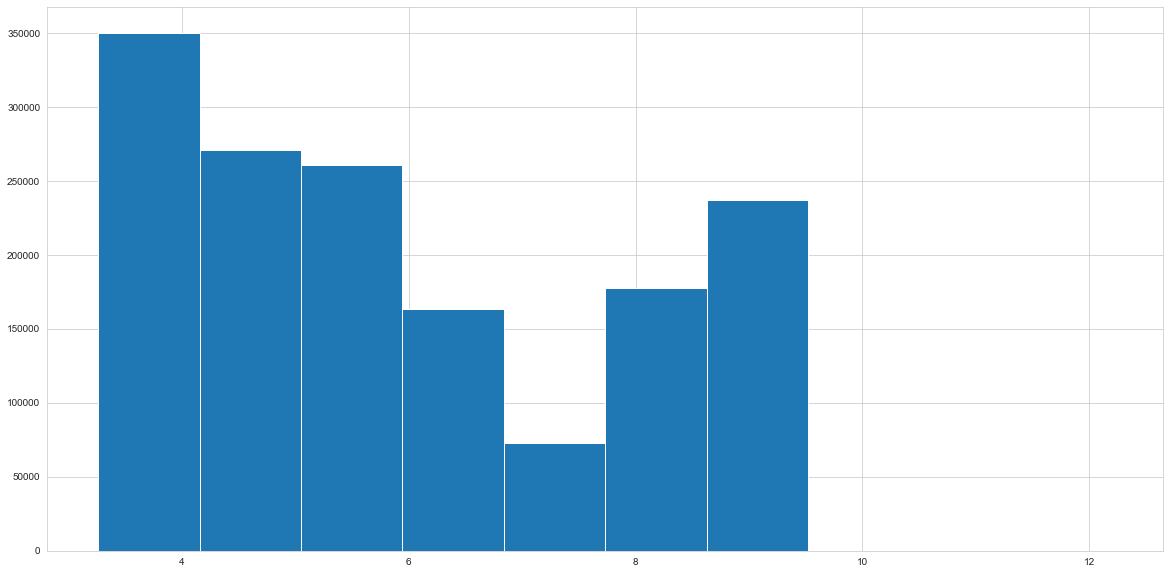

In [120]:
# from AMOUNT_log, anything above 10 can be categorized as anomaly
transaction.AMOUNT_log.hist()

<AxesSubplot:>

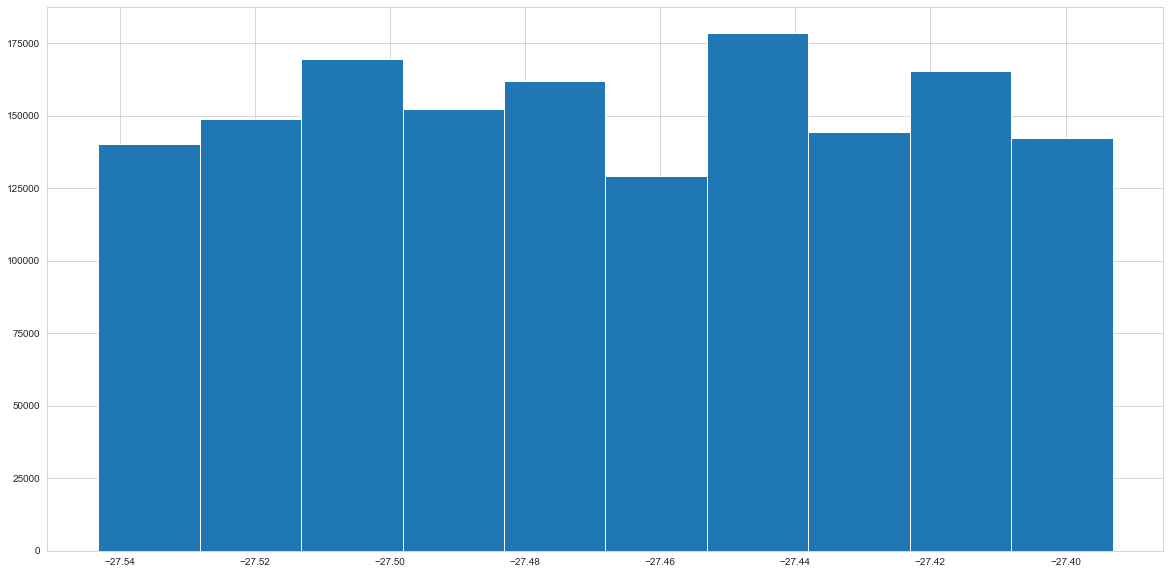

In [119]:
# FROMACCT_ADDRESS_LAT, evenly distributed across all measures, not easily identify any anomaly from this single metric
transaction.FROMACCT_ADDRESS_LAT.hist()

<AxesSubplot:>

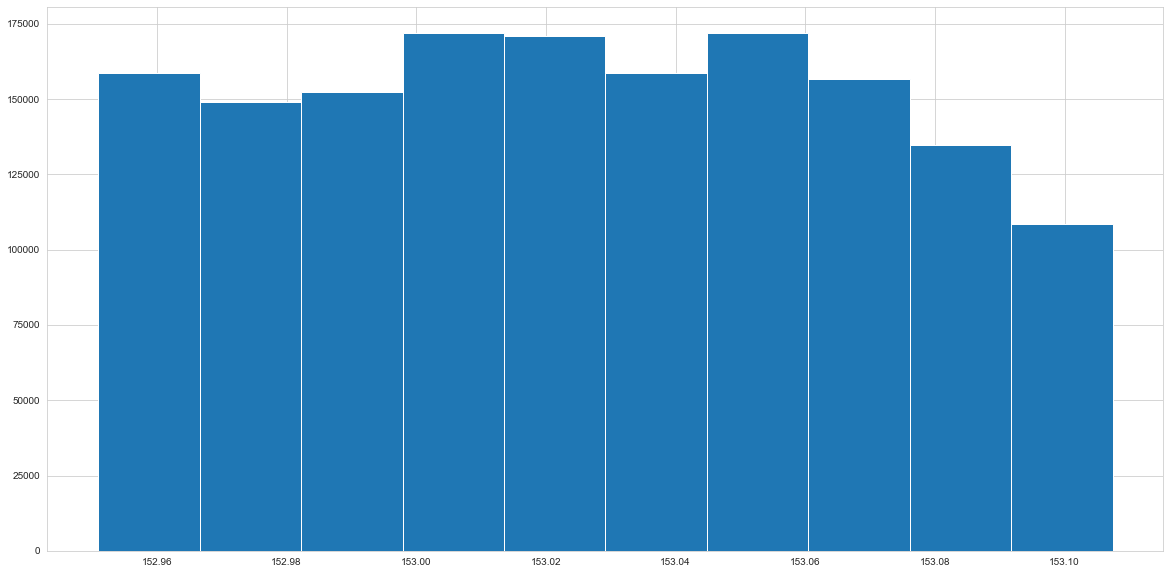

In [122]:
# FROMACCT_ADDRESS_LON, evenly distributed across all measures, not easily identify any anomaly from this single metric
transaction.FROMACCT_ADDRESS_LON.hist()

<AxesSubplot:>

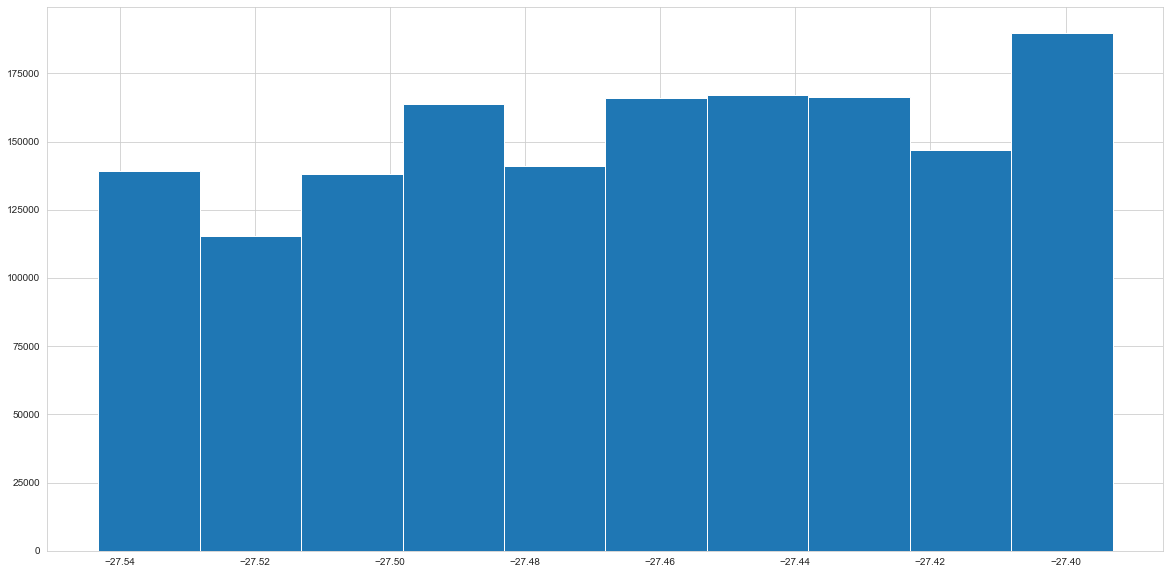

In [123]:
# TOACCT_ADDRESS_LON, evenly distributed across all measures, not easily identify any anomaly from this single metric
transaction.TOACCT_ADDRESS_LAT.hist()

<AxesSubplot:>

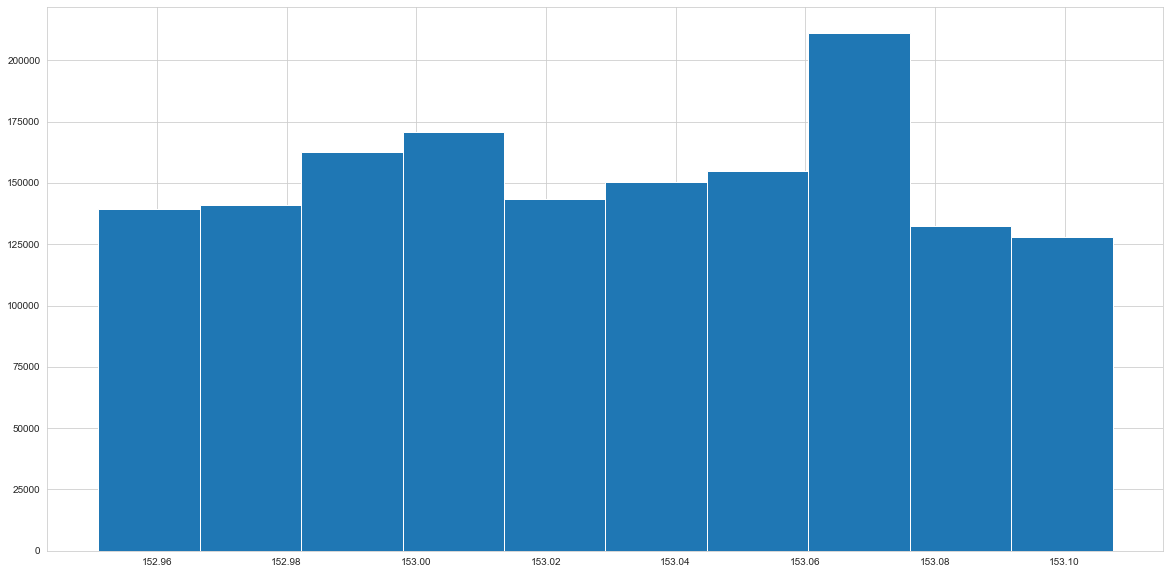

In [124]:
# TOACCT_ADDRESS_LON, evenly distributed across all measures, not easily identify any anomaly from this single metric
transaction.TOACCT_ADDRESS_LON.hist()

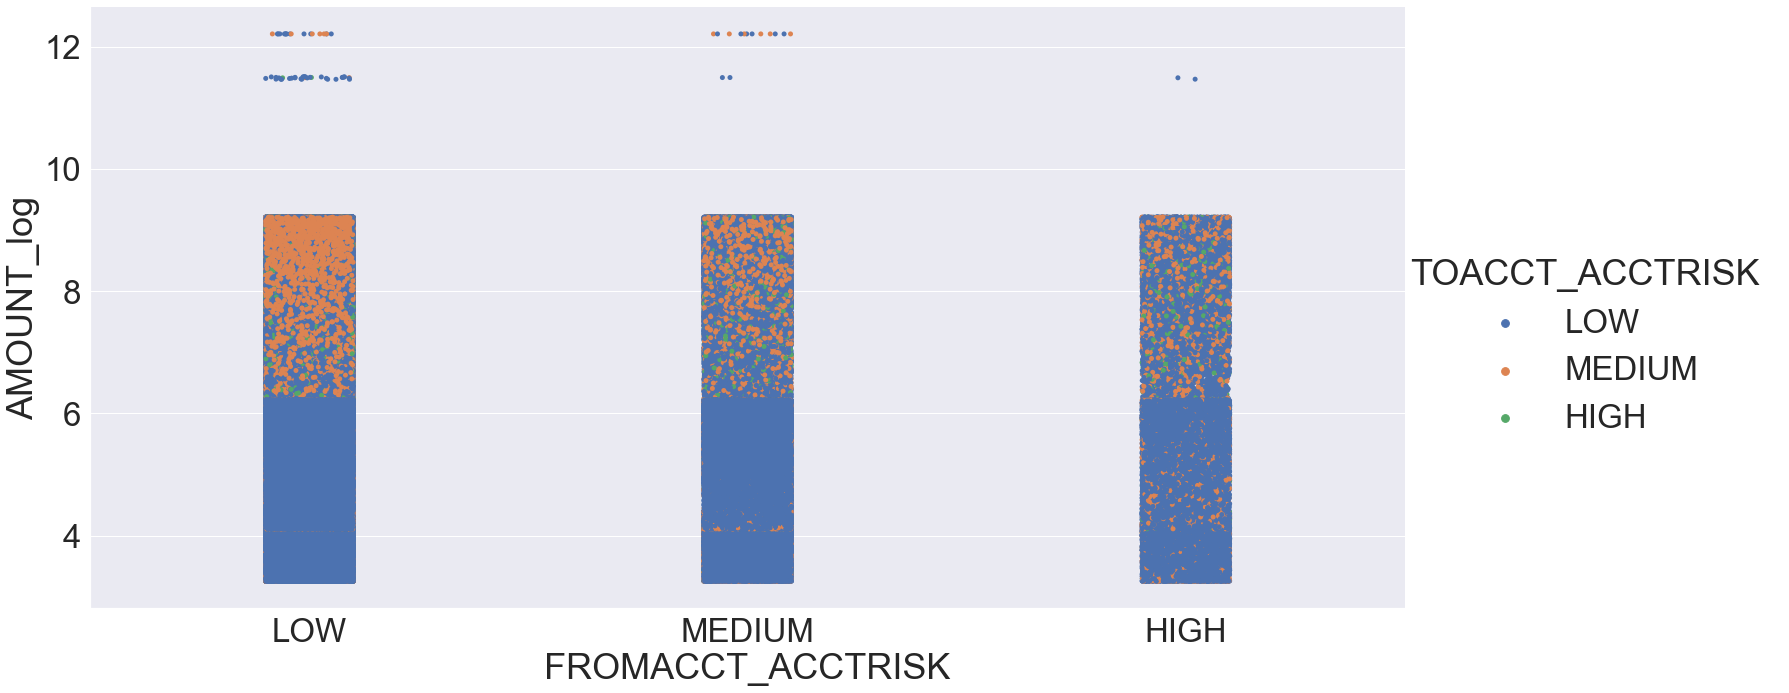

In [127]:
# when AMOUNT_log > 10, FROMACCT_ACCTRISK == 'HIGH', transactions can be treated as anomaly
sns.set(font_scale=3)
sns.catplot(x='FROMACCT_ACCTRISK', y='AMOUNT_log', data=transaction, hue='TOACCT_ACCTRISK',
            height=10, aspect=2)

In [150]:
reference_count = transaction[['REFERENCE', 'AMOUNT']].groupby(by='REFERENCE').count().sort_values(by='AMOUNT',ascending=True)
reference_count.columns = ['COUNT']
reference_count

,COUNT
REFERENCE,
Meal with Terrance,19
Meal with Terrence,20
Breakfast with Vernon,20
Meal with Leon,20
Meal with Gilbert,21
...,...
Payment for Job,63858
Water Costs,63974
Paid for FixUp,64054


array([[<AxesSubplot:title={'center':'COUNT'}>]], dtype=object)

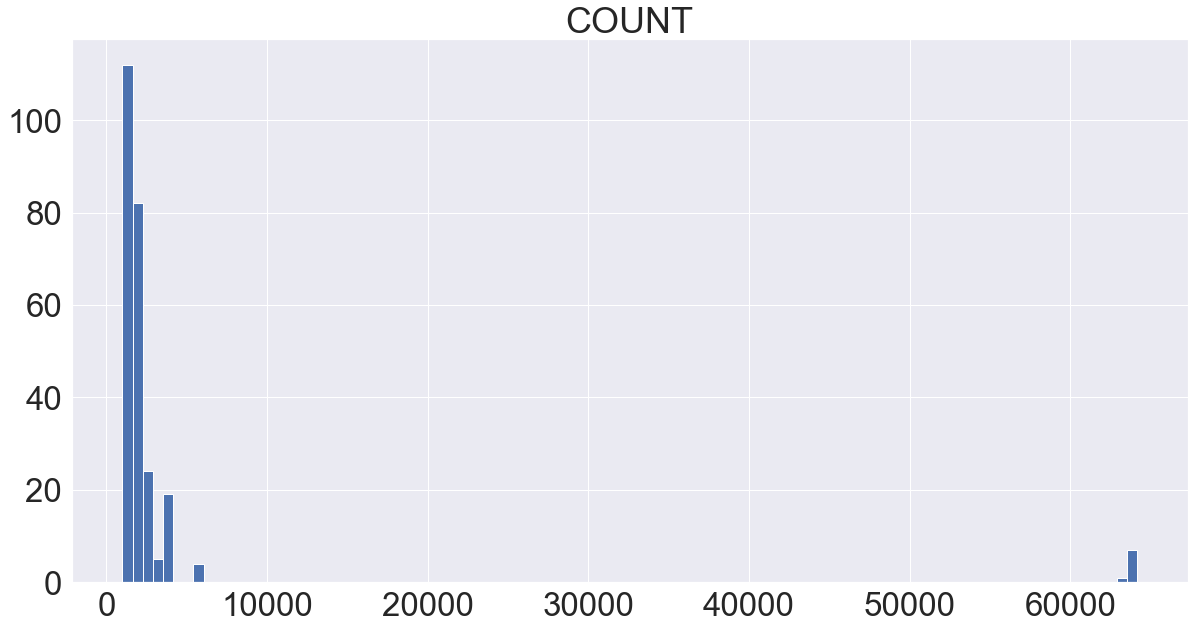

In [159]:
#count > 60000 should be anomaly
reference_count[reference_count.COUNT>1000].hist(bins=100)

In [160]:
reference_mean = transaction[['REFERENCE', 'AMOUNT']].groupby(by='REFERENCE').mean().sort_values(by='AMOUNT',ascending=True)
reference_mean.columns = ['Average']
reference_total

,TOTAL
REFERENCE,
Breakfast with Fred,45.392157
Coffee with Mia,46.000000
Coffee with Gregg,46.529412
Breakfast with Dave,46.833333
Coffee with Sergio,46.935484
...,...
Gift Costs,5262.817288
Payment for Job,5262.965674
Instalment,5267.460518


array([[<AxesSubplot:title={'center':'Average'}>]], dtype=object)

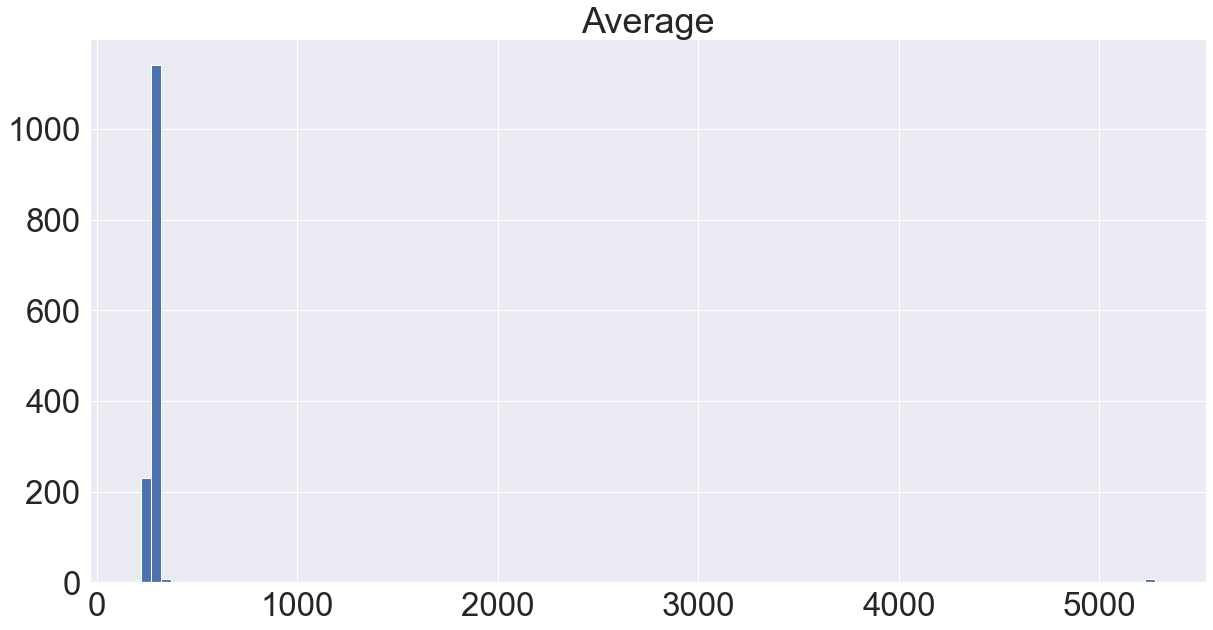

In [161]:
# seems like if the mean amount of the reference category is over 5000, they look like outliers
reference_mean[reference_mean.Average > 200].hist(bins=100)

In [60]:
# all the values are 'N'. carries no information
transaction.ISFRAUD.unique()

array(['N'], dtype=object)

In [61]:
# all the values are 'Y'. carries no information
transaction.ISFLAGGED.unique()

array(['Y'], dtype=object)

In [169]:
account_count = transaction[['FROMACCTID', 'TOACCTID','AMOUNT']].groupby(by=['FROMACCTID', 'TOACCTID']).count().sort_values(by='AMOUNT',ascending=True)
account_count = account_count.dropna()

In [175]:
account_count.columns = ['count_total']
account_count

count_total
FROMACCTID TOACCTID             
800435     500801            1.0
500577     501218            1.0
           501217            1.0
501064     500216            1.0
500577     501210            1.0
...                          ...
501109     800103           14.0
501319     800294           14.0
500540     800261           14.0
501364     800274           14.0
501146     800281           14.0

[722654 rows x 1 columns]

array([[<AxesSubplot:title={'center':'count_total'}>]], dtype=object)

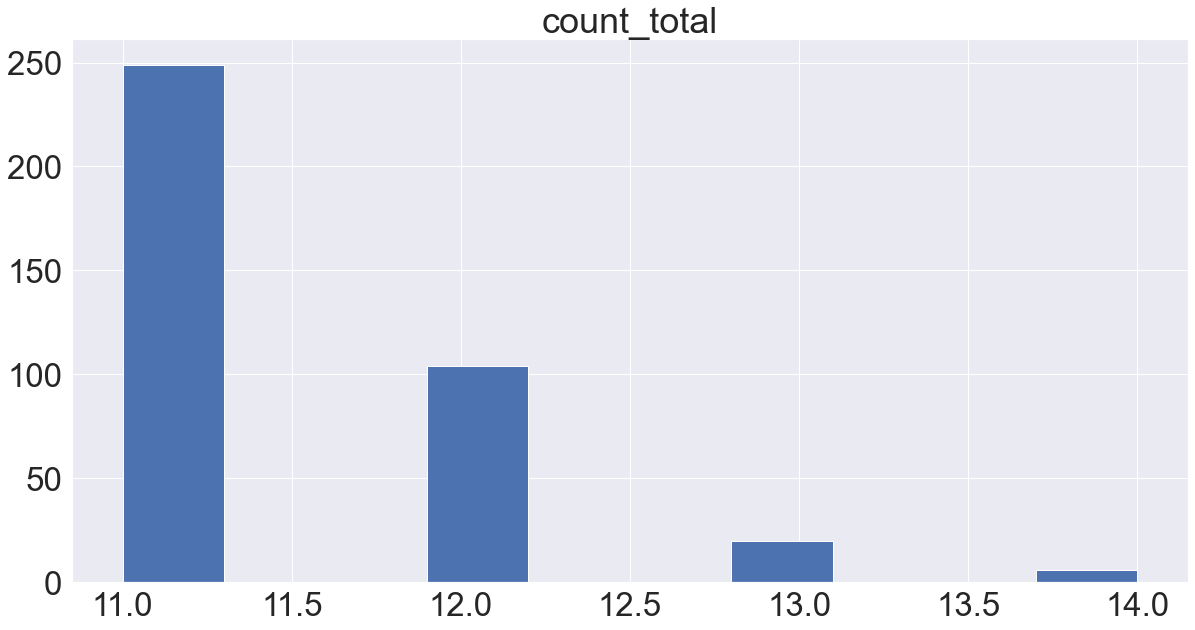

In [176]:
# seems normal
account_count[account_count.count_total>10].hist()

In [92]:
#ACCTNAME seems to contain information from FIRSTNAME and SURENAME, 
# so FIRSTNAME and SURNAME may not need to be in the feature list for predictive modeling
transaction[['FROMACCT_ACCTNAME', 'FROMACCT_FIRSTNAME','FROMACCT_SURNAME']]

,FROMACCT_ACCTNAME,FROMACCT_FIRSTNAME,FROMACCT_SURNAME
0,"Gutierrez, Jenna",Jenna,Gutierrez
1,"Gutierrez, Jenna",Jenna,Gutierrez
2,"Burgess, Shelley",Shelley,Burgess
3,"Dennis, Thomas",Thomas,Dennis
4,"Wagner, Nicole",Nicole,Wagner
...,...,...,...
1533061,Price Consulting,Jennifer,Price
1533062,Sanders Finance,Randy,Sanders
1533063,Sanders Finance,Randy,Sanders
1533064,Sutton Trading,Kathleen,Sutton


In [177]:
transaction.TXDATE.min()

Timestamp('2019-10-02 08:00:00')

In [178]:
transaction.TXDATE.max()

Timestamp('2020-09-30 17:00:00')

<AxesSubplot:>

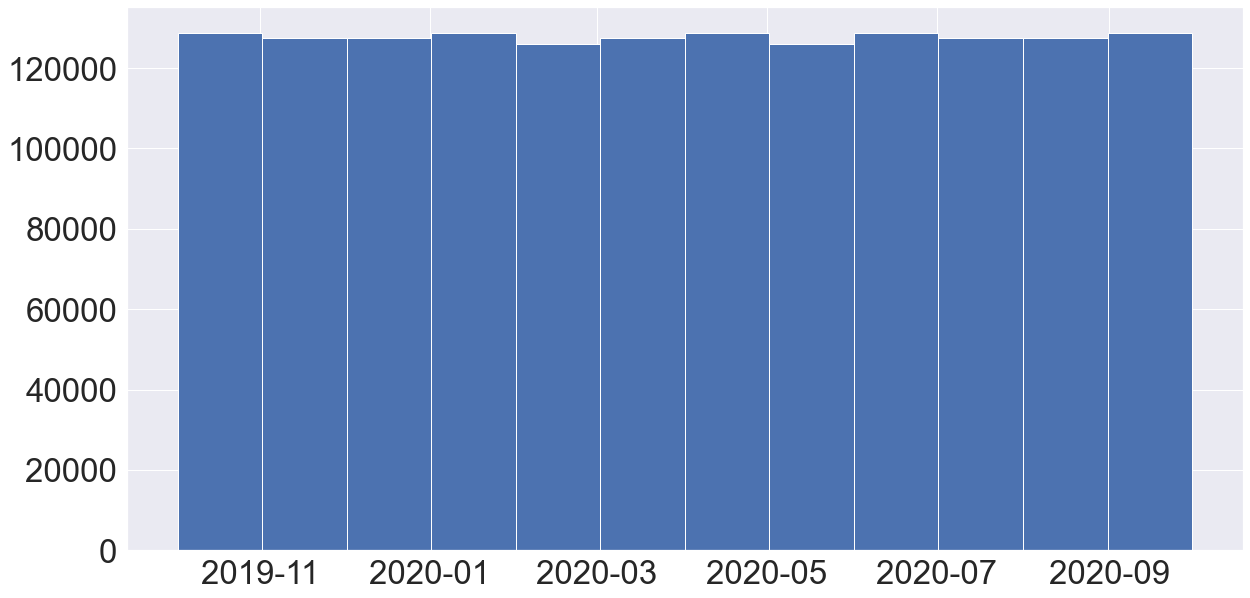

In [179]:
#dates are very evenly distributed
transaction.TXDATE.hist(bins=12)

In [180]:
# distribution across month seems similar
transaction_date = transaction.set_index('TXDATE')
transaction_month = transaction_date.resample('M').mean()
transaction_month

,AMOUNT,FROMACCT_ADDRESS_LAT,FROMACCT_ADDRESS_LON,TOACCT_ADDRESS_LAT,TOACCT_ADDRESS_LON,AMOUNT_log
TXDATE,,,,,,
2019-10-31,1851.020063,-27.467967,153.026534,-27.463880,153.029491,5.932428
2019-11-30,1863.122286,-27.467967,153.026534,-27.464099,153.029417,5.935841
2019-12-31,1848.113579,-27.467967,153.026534,-27.464303,153.029263,5.932691
2020-01-31,1852.777896,-27.467967,153.026534,-27.463985,153.029391,5.933273
2020-02-29,1905.730510,-27.467964,153.026533,-27.464148,153.029336,5.937795
2020-03-31,1858.757727,-27.467967,153.026534,-27.464146,153.029395,5.933417
2020-04-30,1889.482600,-27.467960,153.026532,-27.464119,153.029353,5.938820
2020-05-31,1861.652596,-27.467967,153.026534,-27.464158,153.029442,5.932268
2020-06-30,1862.015833,-27.467967,153.026534,-27.463923,153.029543,5.937072
